In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import stim
print(stim.__version__)

import matplotlib.pyplot as plt
import numpy as np
import math

from ldpc import bp_decoder, bposd_decoder
import time
from src.utils import rank
from src.codes_q import *
from src.build_circuit import build_circuit, dem_to_check_matrices
from src import bpgdg_decoder, bpgd_decoder
from src import bp4_osd
from src.simulation import data_qubit_noise_decoding

1.13.dev1701377008


# BP4+OSD [1]

For the BP4 part, I rewrote my [TensorFlow implementation](https://github.com/gongaa/Feedback-GNN/blob/main/sionna/fec/ldpc/decoding_q.py) in the `mod2sparse` framework. Since I only worked on CSS codes, I do OSD for X and Z errors **separately**.
More specifically, after BP4, I obtain the posterior probability of each bit suffering from bit and phase flip separately, rank the columns accordingly and then do (possibly higher-order) OSD. 
[1] is using serial scheduling for BP, while I am using flooding scheduling, therefore, I use more BP iterations.

In [6]:
# code = create_generalized_bicycle_codes(23, [0,5,8,12], [0,1,5,7])                      # [[46,2,9]]
# code = create_generalized_bicycle_codes(127, [0,15,20,28,66], [0,58,59,100,121])        # [[254,28,14<=d<=20]]
code = create_QC_GHP_codes(63, create_cyclic_permuting_matrix(7, [27,54,0]), [0,1,6])     # [[882,24,18<=d<=24]]
print(code.name)

num_shots = 100000
p = 0.1
print(f"Depolarize({p})")
px, py, pz = p/3*np.ones(code.N), p/3*np.ones(code.N), p/3*np.ones(code.N)
noise = np.random.uniform(0, 1, (num_shots,code.N))
err_z = np.logical_and(noise > px, noise < (px+py+pz))
syndrome_x = (err_z @ code.hx.T) % 2 # [num_shots, N_half]
err_x = noise < (px+py)
syndrome_z = (err_x @ code.hz.T) % 2 # [num_shots, N_half]
num_flag_err = 0

bpd = bp4_osd(code.hx, code.hz, 
              channel_probs_x=px, 
              channel_probs_y=py, 
              channel_probs_z=pz,
              max_iter=100,
              ms_scaling_factor=0.625,
              osd_method="osd_cs",
              osd_order=10)

start_time = time.perf_counter()
num_log_err = 0
num_osd0_log_err = 0
for i in range(num_shots):
    e_hat = bpd.decode(syndrome_x[i], syndrome_z[i])  # input syndrome
    e_hat_x, e_hat_z = e_hat[0], e_hat[1]
    e_diff_z = (e_hat_z + err_z[i]) % 2
    logical_z_err = ((e_diff_z @ code.hz_perp.T) % 2).any()   # capture convergence test  
    e_diff_x = (e_hat_x + err_x[i]) % 2
    logical_x_err = ((e_diff_x @ code.hx_perp.T) % 2).any()
    num_log_err += (logical_z_err or logical_x_err)
    
    e_hat_x, e_hat_z = bpd.osd0_decoding_x, bpd.osd0_decoding_z
    e_diff_z = (e_hat_z + err_z[i]) % 2
    logical_z_err = ((e_diff_z @ code.hz_perp.T) % 2).any()   # capture convergence test  
    e_diff_x = (e_hat_x + err_x[i]) % 2
    logical_x_err = ((e_diff_x @ code.hx_perp.T) % 2).any()
    num_osd0_log_err += (logical_z_err or logical_x_err)
    
    num_flag_err += 1 - bpd.converge     # get whether plain BP4 converged
    
print(f"BP4: num flagged error {num_flag_err}/{num_shots}")
print(f"BP4+OSD0: num logical error {num_osd0_log_err}/{num_shots}, LER {num_osd0_log_err/num_shots}")
print(f"BP4+OSD: num logical error {num_log_err}/{num_shots}, LER {num_log_err/num_shots}")
end_time = time.perf_counter()
print("Elapsed time:", end_time-start_time) 

GHP_n882_k24
Depolarize(0.1)
BP4: num flagged error 18372/100000
BP4+OSD0: num logical error 77/100000, LER 0.00077
BP4+OSD: num logical error 22/100000, LER 0.00022
Elapsed time: 1151.7065227439998


# 2BGA codes [2]

$H_X=[A|B]$, $H_Z=[B^T|A^T]$ where the $l\times l$ matrices $A=L(a)$ and $B=R(b)$ are defined by the left and right action on group elements, $l$ is the group size.
$$[L(a)]_{\alpha,\beta}=\sum_{g\in G} a_g \delta_{\alpha,g\beta}\quad [R(b)]_{\alpha,\beta}=\sum_{g\in G} b_g \delta_{\alpha, \beta g}$$ 

Among all the codes listed in Table 1 of [2], I only implemented the univariate codes and those with structure of semi-direct product of two cyclic codes. Here is some explanation and notation (different from [2]) on how I implemented the later.

$G=C_n \rtimes C_m$, $C_n$ is normal in $G$. Since G is the semi-direct product of two cyclic code, G has the presentation $\langle r,s|r^n=1, s^m=1, s^{-1}rs=r^k\rangle$, $k^m\equiv 1 (\text{mod}\ \phi(n))$. The conjugation $srs^{-1}=r^{k_{inv}}$ where $k\cdot k_{inv}\equiv 1 (\text{mod}\ n)$. 

- Each element of $G$ can be represented as $(a,b)$ which is $r^a s^b$ in the free group, where $a\in C_n$, $b\in C_m$ are powers of $r$ and $s$, respectively.

- To multiply $(a,b)$ and $(c,d)$ in $G$, use the rule $(a,b)(c,d)=(a(b\cdot c),bd)$, where $b\cdot c$ denotes the action of $b$ on $c$ as per the rule $srs^{-1}=r^{k_{inv}}$. This rule implies $sr^c s^{-1}=r^{ck_{inv}}$ and $s^{b}r^c s^{-b}=r^{ck_{inv}^b}$. Sanity check: $r^a s^b r^c s^d = r^{a+c k_{inv}^b}s^{b+d}$.

$[[72,8,9]]$: $a=1+r$, $b=1+s+r^6+s^3 r+s r^7+s^3 r^5$, $\langle r,s\vert r^9,s^4,s^{-1}rs=r^{-1} \rangle$, $C_9 \rtimes C_4$

$[[80,8,10]]$: $a=1+rs^4$, $b=1+s+s^2+r+r^3s+r^2s^6$, $\langle r,s\vert r^5,s^8,s^{-1}rs=r^{-1}\rangle$, $C_5 \rtimes C_8$

$[[72,8,9]]$: $a=1+s+r+sr^6$, $b=1+s^2 r+s^2 r^6+r^2$, $\langle r,s\vert r^9,s^4,s^{-1}rs=r^{-1}\rangle$, $C_9\rtimes C_4$

$[[80,8,10]]$: $a=1+s+r+r^3 s^5$, $b=1+s^2+r s^4+r^3 s^2$, $\langle r,s\vert r^5, s^8, s^{-1}rs=r^{-1} \rangle$, $C_5\rtimes C_8$

$[[96,8,12]]$: $a=1+s+r+s^{14}$, $b=1+s^2+rs^4+s^{11}$, $\langle r,s\vert r^3, s^{16}, s^{-1}rs=r^{-1} \rangle$, $C_3\rtimes C_{16}$

$[[96,10,12]]$: $a=1+s+r^9+sr$, $b=1+s^2 r^9+r^7+r^2$, $\langle r,s|r^{12},s^4, s^{-1}rs=r^{-1} \rangle$, $C_{12}\rtimes C_4$

2GBA_n96_k10 girth 4
2GBA_n96_k10 girth 4


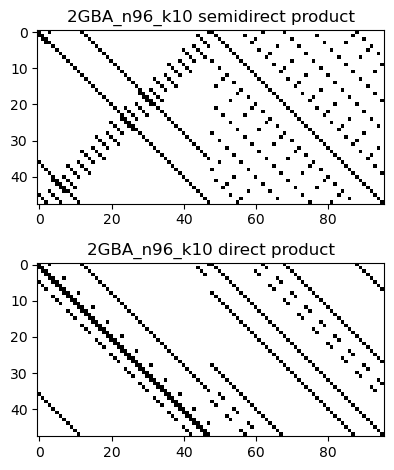

In [16]:
# k_{inv} = k = -1
code = create_2BGA(9, 4, -1, [(0,0),(0,1)], [(0,0),(1,0),(0,6),(3,1),(1,7),(3,5)], sr=True) # [[72,8,9]]
code = create_2BGA(5, 8, -1, [(0,0),(0,4)], [(0,0), (0,1), (0,2), (1,0), (3,1), (2,6)])     # [[80,8,10]]
code = create_2BGA(9, 4, -1, [(0,0),(1,0),(0,1),(1,6)], [(0,0),(2,1),(2,6),(0,2)], sr=True) # [[72,8,9]]
code = create_2BGA(5, 8, -1, [(0,0),(0,1),(1,0),(3,5)], [(0,0),(0,2),(1,4),(3,2)])          # [[80,8,10]]
code = create_2BGA(3, 16, -1,[(0,0),(0,1),(1,0),(0,14)],[(0,0),(0,2),(1,4),(0,11)])         # [[96,8,12]]

plt.subplot(2,1,1)
code = create_2BGA(12, 4, -1, [(0,0),(1,0),(0,9),(1,1)], [(0,0),(2,9),(0,7),(0,2)], sr=True) # [[96,10,12]]
print(code.name, "girth", find_girth(code.hz))
plt.title(f"{code.name} semidirect product")
plt.imshow(code.hx, cmap="gist_yarg")

plt.subplot(2,1,2)
# use k_{inv} = k = 1 for direct product
code = create_2BGA(12, 4, 1, [(0,0),(1,0),(0,9),(1,1)], [(0,0),(2,9),(0,7),(0,2)], sr=True)  # [[96,10,?]]
print(code.name, "girth", find_girth(code.hz))
plt.title(f"{code.name} direct product")
plt.imshow(code.hx, cmap="gist_yarg")
plt.tight_layout()
# from my experience, these short block-length semidirect and direct product constructed codes
# do not differ much in logical error rate performance under data qubit noise decoding


code = create_generalized_bicycle_codes(36, [0,28], [0,9,18,12,29,14]) # [[72,8,9]]
code = create_generalized_bicycle_codes(27, [0,1,3,7], [0,1,12,19])    # [[54,6,9]]
code = create_generalized_bicycle_codes(30, [0,10,6,13], [0,25,16,12]) # [[60,6,10]]
code = create_generalized_bicycle_codes(35, [0,15,16,18], [0,1,24,27]) # [[70,8,10]]
code = create_generalized_bicycle_codes(36, [0,9,28,31], [0,1,21,34])  # [[72,8,10]]
code = create_generalized_bicycle_codes(36, [0,9,28,13], [0,1,3,22])   # [[72,10,9]]


In [9]:
code = create_2BGA(12, 4, 1, [(0,0),(1,0),(0,9),(1,1)], [(0,0),(2,9),(0,7),(0,2)], sr=True)  # [[96,10,?]]
data_qubit_noise_decoding(code=code, p=0.03, num_shots=100000, osd_factor=0.5)
data_qubit_noise_decoding(code=code, p=0.02, num_shots=1000000, osd_factor=0.5)

hx shape (48, 96), hz_perp shape (53, 96)
OSD order 0: num logical error 1356/100000, LER 0.01356
OSD order 10: num logical error 445/100000, LER 0.00445
Elapsed time: 2.3622619844973087
GDG: num flagged error 2
GDG: num logical error 314/100000, LER 0.00314
Elapsed time: 5.438474269583821
hx shape (48, 96), hz_perp shape (53, 96)
OSD order 0: num logical error 1844/1000000, LER 0.001844
OSD order 10: num logical error 485/1000000, LER 0.000485
Elapsed time: 16.55498756840825
GDG: num flagged error 1
GDG: num logical error 269/1000000, LER 0.000269
Elapsed time: 17.810128185898066


# Finite Geometry Codes and CAMEL decoding [3]

In [2], CSS type of codes described by $\mathbf{H}_X=(\mathbf{H}_1 | \mathbf{1}_{m\times 1})$ and $\mathbf{H}_Z=(\mathbf{H}_2 | \mathbf{1}_{m\times 1})$ that assemble four-cycles onto a single VN (the last one) are constructed. Where $\mathbf{H}_1, \mathbf{H}_2\in\mathbb{F}_2^{m\times n}$ satisfy $\mathbf{H}_1 \mathbf{H}_2^T=\mathbf{I}_{m\times m}$, so that $\mathbf{H}_X \mathbf{H}_Z^T=\mathbf{0}$.

By removing the last VN (represented by the last column), all four-cycles disappear. CAMEL decoding decimates the last VN to $I,X,Y,Z$ and do usual BP4 decoding on the remaining Tanner graph $(\mathbf{H}_1,\mathbf{H}_2)$ respectively for these four decimation values. The answer with the highest probability among the four options is chosen and returned.

The codes shown in [3] have very good parameters, and even more desirable is the great performance under BP decoding. However, it is a bit unclear to me whether this kind of code construction could allow a low-depth syndrome measurement circuit. As one can see, the last VN is involved in all the checks.

When $\mathbf{H}_1=\mathbf{H}_2$ are type-II 2D finite geometry codes (see [4] for details), the resulting QLDPC codes can have extremely high rate with approximated $\sqrt{N}$ distance. Type-II means the columns represent the lines and the rows are the points. Define a one in the PCM if a column passes through a point.

Let $EG$($m$, $2^s$) be an m-dimensional Euclidean geometry over the Galois field $GF$($2^s$). In the following, only consider $m=2$. Let $\alpha$ be a primitive element of the extension field $GF$($2^{2s}$). $0=\alpha^{\infty}, \alpha^0,\alpha^1,\alpha^2,\dots,\alpha^{2^{2s}-2}$ form the $2^{2s}$ points of $EG$($2$, $2^s$). The collection of the following points,
$$\{\alpha^i + \beta \alpha^j\}:=\{\alpha^i + \beta \alpha^j: \beta\in GF(2^s)\}$$
form a line in $EG$($2$, $2^s$). In my implementation, I take $\beta=\alpha^{2^s+1}$ (order $2^s-1$). I use the Conway polynomial to define $GF$($2^{2s}$), the primitive element is just $x$. In order to calculate the sum of two elements in $GF$($2^{2s}$), I construct a vector whose $i^{th}$ entry stores the value $j$ that satisfies $\alpha^j=1+\alpha^i$. (One can also use this vector to implement projective geometry code constructions.) The rest of the implementation is just calculating for each line its incidence relationship/vector with all the points. Remove duplicate incidence vectors at the end. 


In [4]:
code = create_cycle_assemble_codes(7, 3)  # [[50,12,6]]
print(code.name)
code = create_cycle_assemble_codes(11, 2) # [[122,20,12]]
print(code.name)
code = create_cycle_assemble_codes(13, 2) # [[170,24,14]]
print(code.name)
code = create_cycle_assemble_codes(17 ,3) # [[290,32,18]]
print(code.name)
code = create_cycle_assemble_codes(19, 3) # [[362,36,20]]
print(code.name)
code = create_EG_codes(1) # [[7,1,3]]
print(code.name)
code = create_EG_codes(2) # [[21,3,5]]
print(code.name)
code = create_EG_codes(3) # [[73,19,9]]
print(code.name)
code = create_EG_codes(4) # [[273,111,17]]
print(code.name)
code = create_EG_codes(5) # [[1057,571,33]]
print(code.name)

CAMEL_n50_k12
CAMEL_n122_k20
CAMEL_n170_k24
CAMEL_n290_k32
CAMEL_n362_k36
EG_n7_k1
EG_n21_k3
EG_n73_k19
EG_n273_k111
EG_n1057_k571


In [5]:
code = create_cycle_assemble_codes(19, 3) # [[362,36,20]]
num_shots = 100000
p = 0.02
px, py, pz = p/3*np.ones(code.N), p/3*np.ones(code.N), p/3*np.ones(code.N)
noise = np.random.uniform(0, 1, (num_shots,code.N))
err_z = np.logical_and(noise > px, noise < (px+py+pz))
syndrome_x = (err_z @ code.hx.T) % 2 # [num_shots, N_half]
err_x = noise < (px+py)
syndrome_z = (err_x @ code.hz.T) % 2 # [num_shots, N_half]
num_flag_err = 0

bpd = bp4_osd(code.hx, code.hz, 
              channel_probs_x=px, 
              channel_probs_y=py, 
              channel_probs_z=pz,
              max_iter=50,
              ms_scaling_factor=0.8, # use 0.625 for N=1057
              osd_method="osd0",
              osd_order=-1) # not using osd

start_time = time.perf_counter()
num_log_err = 0
for i in range(num_shots):
    e_hat = bpd.camel_decode(syndrome_x[i], syndrome_z[i])  # input syndrome
    e_hat_x, e_hat_z = e_hat[0], e_hat[1]
    e_diff_z = (e_hat_z + err_z[i]) % 2
    logical_z_err = ((e_diff_z @ code.hz_perp.T) % 2).any()   # capture convergence test  
    e_diff_x = (e_hat_x + err_x[i]) % 2
    logical_x_err = ((e_diff_x @ code.hx_perp.T) % 2).any()
    num_log_err += (logical_z_err or logical_x_err)
    
    num_flag_err += 1 - bpd.converge     # get whether plain BP4 converged
    
print(f"BP4: num flagged error {num_flag_err}/{num_shots}")
print(f"CAMEL: num logical error {num_log_err}/{num_shots}, LER {num_log_err/num_shots}")
end_time = time.perf_counter()
print("Elapsed time:", end_time-start_time) 

BP4: num flagged error 26/100000
CAMEL: num logical error 26/100000, LER 0.00026
Elapsed time: 2447.1610257662833


# BPGD [5]

The `bpgd_decoder` can be plugged into sliding window decoder, it will follow the same BP pre-processing as GDG on each window (keeping the `2*num_row` columns afterwards), if you set `max_iter` to the same value as GDG. You will need to change `max_step` to `2*num_row` for the window PCM, if you want to allow all VNs being possibly decimated.

In [7]:
code = create_QC_GHP_codes(63, create_cyclic_permuting_matrix(7, [27,54,0]), [0,1,6])   # [[882,24,18<=d<=24]]
priors = 0.04 * np.ones(code.N)
bpgd_all = bpgd_decoder(
    code.hx,
    channel_probs=priors,
    max_step=code.N, # allow decimating all VNs
    max_iter_per_step=12, # please use a multiple of four
    gd_factor=0.8,   # the best among {0.5,0.625,0.8,1.0}
    max_iter=0,      # no BP preprocessing
)

bpgd_partial = bpgd_decoder(
    code.hx,
    channel_probs=priors,
    max_step=100, # decimation stops after 100 rounds
    max_iter_per_step=12,
    gd_factor=0.8,
    max_iter=0,
)

# evaluate the two BPGD decoders,together with OSD-CS10, OSD0, GDG over the SAME set of generated noise
data_qubit_noise_decoding(code=code, p=0.04, num_shots=1000000, 
                          extra_decoders=[bpgd_all, bpgd_partial], # `decode` and `converge` will be called
                          osd_orders=[10], osd_factor=0.625,                   # OSD settings
                          max_step=80, max_tree_step=60, max_iter_per_step=8   # GDG settings
                         )


hx shape (441, 882), hz_perp shape (453, 882)
Extra decoder: num flagged error 34
Extra decoder: num logical error 34/1000000, LER 3.4e-05
Elapsed time: 431.81932934400174
Extra decoder: num flagged error 551
Extra decoder: num logical error 551/1000000, LER 0.000551
Elapsed time: 419.96941065699866
OSD order 0: num logical error 26/1000000, LER 2.6e-05
OSD order 10: num logical error 1/1000000, LER 1e-06
Elapsed time: 2168.4583696890004
GDG: num flagged error 20
GDG: num logical error 20/1000000, LER 2e-05
Elapsed time: 4562.919128013997


Disclaimer: For CAMEL and BPGD, I did not fully reproduce their numerical results, because I was using (normalized) min-sum rule for CN update, while they are using sum-product. One can write a sum-product rule in LLR form in BPGD.cpp (see my `min_sum_log` function). Note that when I implemented min-sum, I clipped the message to [-50,50] after the CN update, but for sum-product, you need to clip the message before the CN update, and probably to a smaller value. For example in [Sionna](https://github.com/NVlabs/sionna/blob/main/sionna/fec/ldpc/decoding.py) `_cn_update_phi` implementation of the box-plus operation (sum-product in LLR form), the message amplitude is clipped to [8.5e-8,16.635532] to prevent underflow/overflow.

Another difference with the BPGD paper is that I handle decimation differently. I use a mask for node status, and skip messages from inactive nodes. Whereas BPGD set message to $\pm 25$ instead of $\infty$, which is required for numerical stability when using sum-product and the finite value does make a difference. 

There is a specific reason for me to avoid using sum-product rule, besides due to min-sum being more hardware-efficient and easier to implement. When I was doing my last project on data qubit decoding, where channel priors are assumed to be identical. Which means when errors are sampled according to a noise level $\epsilon$, setting the decoder prior to $\epsilon$ or $\epsilon_0$ (some pseudo prior) shouldn't make any difference, because the estimated error with the smallest weight is the most-likely one. This is indeed true if I use the min-sum rule, but disagreement appears when sum-product is used. The same effect is also observed in [6], see their Figure 5 and 11 where they vary $\epsilon_0$.

## References 

[1] P. Panteleev and G. Kalachev, “Quantum LDPC codes with almost linear minimum distance,” IEEE Transactions on Information Theory, 2021.

[2] H. Lin and L. Pryadko, "Quantum two-block group algebra codes," arXiv:2306.16400, 2023.

[3] S. Miao, J. Mandelbaum, H. Jäkel, and L. Schmalen, "A joint code and belief propagation decoder design for quantum LDPC codes," arXiv:2401.06874, 2024.

[4] S. Lin and D. J. Costello, Jr., "Error Control Coding: Fundamentals and Applications," Prentice-Hall, 2004.

[5] H. Yao, W. A. Laban, C. Häger, A. G. i Amat, and H. D. Pfister, “Belief propagation decoding of quantum LDPC codes with guided decimation,” arXiv:2312.10950, 2023.

[6] S. Miao, A. Schnerring, H. Li, and L. Schmalen, "Quaternary neural belief propagation decoding of quantum LDPC codes with overcomplete check matrices," arXiv:2308.08208, 2023.
